In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances_argmin, classification_report

from sklearn.cluster import AgglomerativeClustering, KMeans
import scipy.cluster.hierarchy as shc

import seaborn as sns

In [2]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras import regularizers
from sklearn.decomposition import PCA

Using TensorFlow backend.


In [3]:
# Read the data
features = pd.read_csv('./medical/historical_X.dat', header=None, sep=" ").values
actions = pd.read_csv('./medical/historical_A.dat', header=None, sep=" ").values
outcome = pd.read_csv('./medical/historical_Y.dat', header=None, sep=" ").values
observations = features[:, :128]
labels = features[:,128] + features[:,129]*2

In [4]:
pca = PCA(.70)
feat_red = pca.fit_transform(features)

In [44]:
#Start by implementing a model


# -*- Mode: python -*-
# A simple reference recommender
#
#
# This is a medical scenario with historical data. 
#
# General functions
#
# - set_reward
# 
# There is a set of functions for dealing with historical data:
#
# - fit_data
# - fit_treatment_outcome
# - estimate_utiltiy
#
# There is a set of functions for online decision making
#
# - predict_proba
# - recommend
# - observe

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import numpy as np


class NNDoctor_imp:
    def __init__(self, 
                 n_actions=1, 
                 n_outcomes=1, 
                 layer_sizes=[64, 16],
                 batch_size=5,
                 epochs=5,
                 optimizer="adam",
                 loss="binary_crossentropy",
                 alpha = 0.0001):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward
        self.layer_sizes = layer_sizes
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.loss = loss
        self.alpha = alpha
        
    def _default_reward(self, action, outcome):
        return -0.1*action + outcome
        
    def get_params(self, deep=True):
        return {k: v for k, v in self.__dict__.items() if not callable(v)}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def predict_proba(self, X):
        return self.model.predict(X)

    def fit(self, X, y):
        self.model = self.build_network(X, y)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

    def predict(self, Xtest):
        return self.model.predict(Xtest)
    
    def predict_classes(self, X):
        return self.model.predict_classes(X)
    
    def build_network(self, X, y):
        model = Sequential()
        for layer_size in self.layer_sizes:
            model.add(Dense(layer_size, activation='elu',kernel_regularizer=regularizers.l2(self.alpha)))
        model.add(Dense(self.n_outcomes, activation='sigmoid'))
        model.compile(loss=self.loss,
                      optimizer=self.optimizer,
                      metrics=['accuracy'])
        return model
    
    def score(self, X, y):
        return (self.model.predict(X)**2 - y**2).mean()


class NNRecommender:

    #################################
    # Initialise
    #
    # Set the recommender with a default number of actions and outcomes.  This is
    # because the number of actions in historical data can be
    # different from the ones that you can take with your policy.
    model = None
    
    def __init__(self, n_actions, n_outcomes):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward

    ## By default, the reward is just equal to the outcome, as the actions play no role.
    def _default_reward(self, action, outcome):
        return -0.1*action + outcome

    # Set the reward function r(a, y)
    def set_reward(self, reward):
        self.reward = reward
    
    ##################################
    # Fit a model from patient data.
    #
    # This will generally speaking be an
    # unsupervised model. Anything from a Gaussian mixture model to a
    # neural network is a valid choice.  However, you can give special
    # meaning to different parts of the data, and use a supervised
    # model instead.
    def fit_data(self, data):
        print("Preprocessing data")
        return None

    def train_model(self, X, a, y):
        param_grid = {'layer_sizes': [[32, 16], [64, 16]],
        'batch_size': [5, 10],
        'epochs': [1, 5],
        'optimizer': ['Adam', 'sgd'],
        'loss': ['mse'],
        'alpha': [0.001, 0.0001]}
        #self.model = GridSearchCV(NNDoctor(), param_grid, cv=10, n_jobs=4)
        self.model = NNDoctor()
        self.model.fit(np.concatenate((X, a), axis=1), y)
        #print(self.model.best_params_)

    ## Fit a model from patient data, actions and their effects
    ## Here we assume that the outcome is a direct function of data and actions
    ## This model can then be used in estimate_utility(), predict_proba() and recommend()
    def fit_treatment_outcome(self, data, actions, outcome):
        print("Fitting treatment outcomes")
        self.train_model(data, actions, outcome)
        return self.model

    ## Estimate the utility of a specific policy from historical data (data, actions, outcome),
    ## where utility is the expected reward of the policy.
    ##
    ## If policy is not given, simply use the average reward of the observed actions and outcomes.
    ##
    ## If a policy is given, then you can either use importance
    ## sampling, or use the model you have fitted from historical data
    ## to get an estimate of the utility.
    ##
    ## The policy should be a recommender that implements get_action_probability()
    def estimate_utility(self, data, actions, outcome, policy=None):
        if policy is None:
            return self.reward(actions, outcome).mean()
        else:
            #predictions_ones = self.model.predict(np.concatenate((data, np.ones(len(data)).reshape(-1,1)), axis = 1))
            #predictions_zeros = self.model.predict(np.concatenate((data, np.zeros(len(data)).reshape(-1,1)), axis = 1))
            #predictions = np.concatenate((predictions_zeros, predictions_ones), axis=1)
            #policy_actions = np.array([policy.get_action_probabilities(x) for x in data])
            policy_actions = np.array([policy.recommend(x) for x in data])
            predicted_outcomes = self.model.predict(np.concatenate((data, policy_actions.reshape(-1,1)), axis=1))
            return self.reward(policy_actions, predicted_outcomes.reshape(1,-1)).mean()
            #print(policy_actions)
            #res_matrix = np.dot(predictions.T, policy_actions)
            #print(res_matrix)
            #return (-0.1*policy_actions.sum() + (res_matrix[0][0] + res_matrix[1][1])) / len(data)

    # Return a distribution of effects for a given person's data and a specific treatment.
    # This should be an numpy.array of length self.n_outcomes
    def predict_proba(self, data, treatment):
        predictions = self.model.predict(np.concatenate((data, [treatment])).reshape(1,-1)).ravel()
        return predictions
    
    def predict_classes(self, data, treatment):
        predictions = self.model.predict_classes(np.concatenate((data, [treatment])).reshape(1,-1)).ravel()
        return predictions_classes

    # Return a distribution of recommendations for a specific user datum
    # This should a numpy array of size equal to self.n_actions, summing up to 1
    def get_action_probabilities(self, user_data):
        #print("Recommending")
        predictions = []
        for a in range(self.n_actions):
            estimated_outcome = self.model.predict(np.concatenate((user_data, [a])).reshape(1,-1))[0][0]
            estimated_reward = self.reward(a, estimated_outcome)
            predictions.append(estimated_reward)
        return np.exp(predictions)/np.sum(np.exp(predictions))
    
    def estimate_historic_utility(self, data, actions, outcome):
        estimated_outcome = self.model.predict(np.concatenate((data, actions), axis=1))
        #outcome_prob = 1/(1 + np.exp(0.5-estimated_outcome))
        return self.reward(actions, estimated_outcome).mean()

    # Return recommendations for a specific user datum
    # This should be an integer in range(self.n_actions)
    def recommend(self, user_data):
        return np.argmax(self.get_action_probabilities(user_data))

    # Observe the effect of an action. This is an opportunity for you
    # to refit your models, to take the new information into account.
    def observe(self, user, action, outcome):
        return None

    # After all the data has been obtained, do a final analysis. This can consist of a number of things:
    # 1. Recommending a specific fixed treatment policy
    # 2. Suggesting looking at specific genes more closely
    # 3. Showing whether or not the new treatment might be better than the old, and by how much.
    # 4. Outputting an estimate of the advantage of gene-targeting treatments versus the best fixed treatment
    def final_analysis(self):
        return None



In [45]:
class NNDoctor_hist:
    def __init__(self, 
                 n_actions=1, 
                 n_outcomes=1, 
                 layer_sizes=[64, 16],
                 batch_size=5,
                 epochs=5,
                 optimizer="sgd",
                 loss="binary_crossentropy",
                 alpha = 0.0001):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward
        self.layer_sizes = layer_sizes
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.loss = loss
        self.alpha = alpha
        
    def _default_reward(self, action, outcome):
        return -0.1*action + outcome
        
    def get_params(self, deep=True):
        return {k: v for k, v in self.__dict__.items() if not callable(v)}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def predict_proba(self, X):
        return self.model.predict(X)

    def fit(self, X, y):
        self.model = self.build_network(X, y)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

    def predict(self, Xtest):
        return self.model.predict(Xtest)
    
    def predict_classes(self, X):
        return self.model.predict_classes(X)
    
    def build_network(self, X, y):
        model = Sequential()
        for layer_size in self.layer_sizes:
            model.add(Dense(layer_size, activation='elu',kernel_regularizer=regularizers.l2(self.alpha)))
        model.add(Dense(self.n_outcomes, activation='sigmoid'))
        model.compile(loss=self.loss,
                      optimizer=self.optimizer,
                      metrics=['accuracy'])
        return model
    
    def score(self, X, y):
        return (self.model.predict(X)**2 - y**2).mean()
    
    
# fit on actions instead of outcome

class HistoricalRecommender:

    model = None

    def __init__(self, n_actions, n_outcomes):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward

    def _default_reward(self, action, outcome):
        return -0.1*action + outcome

    def set_reward(self, reward):
        self.reward = reward

    def fit_treatment_outcome(self, data, actions, outcome):
        print("Fitting treatment outcomes")
        param_grid = {'layer_sizes': [[32, 16], [64, 16]],
        'batch_size': [5, 10],
        'epochs': [1, 5],
        'optimizer': ['Adam', 'sgd'],
        'loss': ['mse'],
        'alpha': [0.001, 0.0001]}
        #self.model = GridSearchCV(NNDoctor(), param_grid, cv=10, n_jobs=4)
        self.model = NNDoctor(n_actions=self.n_actions, n_outcomes=self.n_outcomes)
        self.model.fit(data, actions)
        #print(self.model.best_params_)
        return self.model

    def estimate_utility(self, data, actions, outcome, policy=None):
        if policy is None:
            return self.reward(actions, outcome).mean()
        else:
            policy_actions = np.array([policy.recommend(x) for x in data])
            #predicted_outcomes = self.model.predict(data)
            return self.reward(policy_actions, outcome).mean() #behind outcome .reshape(1,-1)

    def predict_proba(self, data, treatment):
        #predictions = self.model.predict(np.concatenate((data, [treatment])).reshape(1,-1)).ravel()
        pred = self.model.predict(data)
        return pred

    def predict_classes(self, data, treatment):
        #predictions = self.model.predict(np.concatenate((data, [treatment])).reshape(1,-1)).ravel()
        predictions_classes = self.model.predict_classes(data)
        return predictions_classes

    def get_action_probabilities(self, user_data):
        #print("Recommending")
        predictions = []
        for a in range(self.n_actions):
            #estimated_outcome = self.model.predict(np.concatenate((user_data, [a])).reshape(1,-1))[0][0]
            estimated_outcome = self.model.predict(user_data.reshape(1,-1))[0][0]
            estimated_reward = self.reward(a, estimated_outcome)
            predictions.append(estimated_reward)
        return np.exp(predictions)/np.sum(np.exp(predictions))

    def recommend(self, user_data):
        return np.asscalar(self.model.predict_classes(user_data.reshape(1,-1)))
        #return np.argmax(self.get_action_probabilities(user_data))

    def observe(self, user, action, outcome):
        return None

    def final_analysis(self):
        return None

In [46]:
nn_hist = HistoricalRecommender(n_actions = len(np.unique(actions)), n_outcomes = outcome.shape[1])
nn_imp = NNRecommender(len(np.unique(actions)), outcome.shape[1])

nn_hist_red = HistoricalRecommender(n_actions = len(np.unique(actions)), n_outcomes = outcome.shape[1])
nn_imp_red = NNRecommender(len(np.unique(actions)), outcome.shape[1])
print(len(np.unique(actions)))

f_train, f_test, a_train, a_test, o_train, o_test = train_test_split(features, actions, outcome, test_size=.3)

f_train_red, f_test_red, a_train, a_test, o_train, o_test = train_test_split(feat_red, actions, outcome, test_size=.3)

2


In [47]:
# fit the data on the features and the action (outcome is disregarded here)

nn_hist.fit_treatment_outcome(f_train, a_train, o_train)
nn_imp.fit_treatment_outcome(f_train, a_train, o_train)

nn_hist_red.fit_treatment_outcome(f_train_red, a_train, o_train)
nn_imp_red.fit_treatment_outcome(f_train_red, a_train, o_train)

Fitting treatment outcomes
Fitting treatment outcomes
Fitting treatment outcomes
Fitting treatment outcomes


In [48]:
print(np.concatenate((f_train, a_train), axis=1).shape)
print(f_train.shape)

(7000, 131)
(7000, 130)


In [49]:
print(f_test.shape)
print(a_test.shape)

(3000, 130)
(3000, 1)


In [50]:
# predicts the probability of action 0

nn_hist.predict_proba(f_test, a_test)

array([[0.21154356],
       [0.17390072],
       [0.2399498 ],
       ...,
       [0.18670559],
       [0.20280188],
       [0.16826114]], dtype=float32)

In [51]:
pred = nn_hist.predict_classes(f_test, a_test)

unique, counts = np.unique(pred, return_counts=True)
print('prediction:', dict(zip(unique, counts)))

unique, counts = np.unique(a_test, return_counts=True)
print('actual:', dict(zip(unique, counts)))

print(classification_report(a_test, pred))

prediction: {0: 3000}
actual: {0: 2322, 1: 678}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      2322
           1       0.00      0.00      0.00       678

    accuracy                           0.77      3000
   macro avg       0.39      0.50      0.44      3000
weighted avg       0.60      0.77      0.68      3000



In [52]:
pred_red = nn_hist_red.predict_classes(f_test_red, a_test)

unique, counts = np.unique(pred_red, return_counts=True)
print('prediction:', dict(zip(unique, counts)))

unique, counts = np.unique(a_test, return_counts=True)
print('actual:', dict(zip(unique, counts)))

print(classification_report(a_test, pred_red))

prediction: {0: 2920, 1: 80}
actual: {0: 2322, 1: 678}
              precision    recall  f1-score   support

           0       0.78      0.98      0.87      2322
           1       0.55      0.06      0.12       678

    accuracy                           0.78      3000
   macro avg       0.67      0.52      0.49      3000
weighted avg       0.73      0.78      0.70      3000



In [53]:
action_prob = nn_hist.get_action_probabilities(features[15,:])
#print(action_prob.shape)

In [54]:
nn_hist.get_action_probabilities(features[15,:])

array([0.52497919, 0.47502081])

In [55]:
nn_hist.recommend(features[15,:])

0

In [56]:
recommend = []
for x in range(f_test.shape[0]):
    recommend.append(nn_hist.recommend(features[x,:]))

recommend_pca = []
for x in range(f_test_red.shape[0]):
    recommend_pca.append(nn_hist_red.recommend(feat_red[x,:]))

In [57]:
unique, counts = np.unique(recommend, return_counts=True)
print('actual:', dict(zip(unique, counts)))

actual: {0: 3000}


In [58]:
unique, counts = np.unique(recommend_pca, return_counts=True)
print('actual:', dict(zip(unique, counts)))

actual: {0: 2909, 1: 91}


In [59]:
# Exercise 1.1:
# Implemented estimate_utility above
#rec = RandomRecommender(actions.shape[1], actions.shape[1])
print(nn_hist.estimate_utility(features, actions, outcome))
print(nn_hist.estimate_utility(features, actions, outcome, policy = nn_hist))
print(nn_imp.estimate_utility(features, actions, outcome, policy = nn_imp))

print('with pca:')
print(nn_hist.estimate_utility(features, actions, outcome))
print(nn_hist_red.estimate_utility(feat_red, actions, outcome, policy = nn_hist_red))
print(nn_imp_red.estimate_utility(feat_red, actions, outcome, policy = nn_imp_red))

0.11912
0.1421
0.420233901923895
with pca:
0.11912
0.1393099999999976
0.48436286316871646


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


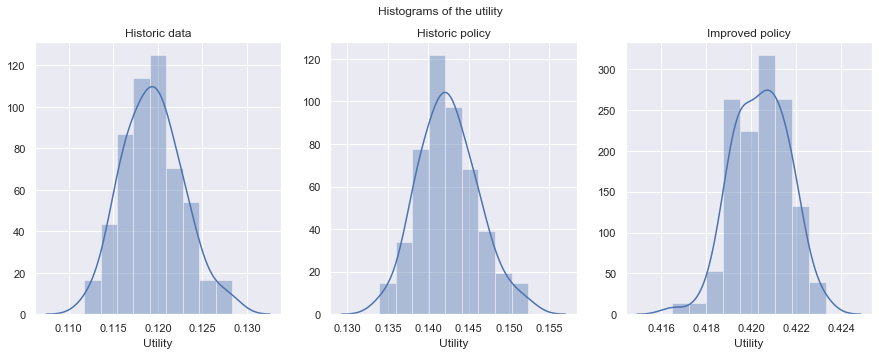

<Figure size 432x288 with 0 Axes>

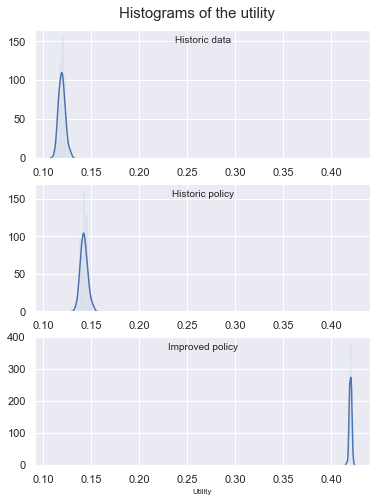

mean utility: 0.1195
Utility std: 0.0033
mean utility hist: 0.1425
Utility std hist: 0.0036
mean utility imp: 0.4204
Utility std imp: 0.0012


In [63]:
# Exercise 1.2:
# Use bootstrap on the historical dataset to estimate variance of the utility
n = features.shape[0]
num_samples = 100
utils = []
utils_hist = []
utils_imp = []
for i in range(num_samples):
    randlist = np.random.randint(n, size=n)
    sample_features = features[randlist]
    sample_actions = actions[randlist]
    sample_outcome = outcome[randlist]
    
    utils.append(nn_hist.estimate_utility(sample_features, sample_actions, sample_outcome))
    utils_hist.append(nn_hist.estimate_utility(sample_features, sample_actions, sample_outcome, policy = nn_hist))
    utils_imp.append(nn_imp.estimate_utility(sample_features, sample_actions, sample_outcome, policy = nn_imp))
    print(i)


fig1, ax = plt.subplots(figsize = (15, 5), ncols = 3)
sns.distplot(utils, ax = ax[0])
sns.distplot(utils_hist, ax = ax[1])
sns.distplot(utils_imp, ax = ax[2])
fig1.suptitle('Histograms of the utility')
ax[0].set_title('Historic data')
ax[1].set_title('Historic policy')
ax[2].set_title('Improved policy')

ax[0].set_xlabel('Utility')
ax[1].set_xlabel('Utility')
ax[2].set_xlabel('Utility')

fig1.savefig('./Images/histograms.png')
plt.show()
plt.clf()

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(6,8))
fig.suptitle('Histograms of the utility', fontsize = 15, y = 0.92)
sns.distplot(utils, ax = ax[0], bins = 20)
ax[0].set_title('Historic data', fontsize = 10, y = 0.85)
ax[0].xaxis.set_tick_params(which='both', labelbottom=True)

sns.distplot(utils_hist, ax = ax[1], bins = 20)
ax[1].set_title('Historic policy', fontsize = 10, y = 0.85)
#plt.setp(ax=ax[1].get_xticklabels(), visible=True)
ax[1].xaxis.set_tick_params(which='both', labelbottom=True)

sns.distplot(utils_imp, ax = ax[2], bins = 20)
ax[2].set_title('Improved policy', fontsize = 10, y = 0.85)
ax[2].set_xlabel('Utility', fontsize = 8)
plt.savefig('./Images/histograms1.png')
plt.show()


print("mean utility: {0:.4f}".format(np.mean(utils)))
print("Utility std: {0:.4f}".format(np.std(utils)))

print("mean utility hist: {0:.4f}".format(np.mean(utils_hist)))
print("Utility std hist: {0:.4f}".format(np.std(utils_hist)))

print("mean utility imp: {0:.4f}".format(np.mean(utils_imp)))
print("Utility std imp: {0:.4f}".format(np.std(utils_imp)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


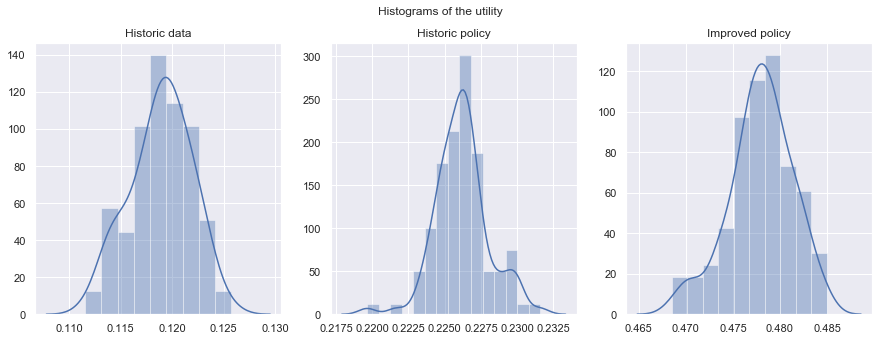

mean utility: 0.1189
Utility std: 0.0030
mean utility hist: 0.2262
Utility std hist: 0.0018
mean utility imp: 0.4780
Utility std imp: 0.0034


<Figure size 432x288 with 0 Axes>

In [61]:
# Exercise 1.2:
# Use bootstrap on the historical dataset to estimate variance of the utility

#for the reduced dataset 
n = feat_red.shape[0]
num_samples = 100
utils = []
utils_hist = []
utils_imp = []
for i in range(num_samples):
    randlist = np.random.randint(n, size=n)
    sample_features = feat_red[randlist]
    sample_actions = actions[randlist]
    sample_outcome = outcome[randlist]
    utils.append(nn_hist_red.estimate_utility(sample_features, sample_actions, sample_outcome))
    utils_hist.append(nn_hist_red.estimate_utility(sample_features, sample_actions, sample_outcome, policy = nn_hist_red))
    utils_imp.append(nn_imp_red.estimate_utility(sample_features, sample_actions, sample_outcome, policy = nn_imp_red))
    print(i)


fig1, ax = plt.subplots(figsize = (15, 5), ncols = 3)
sns.distplot(utils, ax = ax[0])
sns.distplot(utils_hist, ax = ax[1])
sns.distplot(utils_imp, ax = ax[2])
fig1.suptitle('Histograms of the utility')
ax[0].set_title('Historic data')
ax[1].set_title('Historic policy')
ax[2].set_title('Improved policy')
fig1.savefig('./Images/histograms_datared.png')
plt.show()
plt.clf()

print("mean utility: {0:.4f}".format(np.mean(utils)))
print("Utility std: {0:.4f}".format(np.std(utils)))

print("mean utility hist: {0:.4f}".format(np.mean(utils_hist)))
print("Utility std hist: {0:.4f}".format(np.std(utils_hist)))

print("mean utility imp: {0:.4f}".format(np.mean(utils_imp)))
print("Utility std imp: {0:.4f}".format(np.std(utils_imp)))